# exp11: アンサンブル手法の比較

**ベースライン**: exp05のBest Optunaパラメータ使用

**アンサンブルパターン**:
1. 重み付けアンサンブル (最適化あり)
   - Pattern A: Ridge + CatBoost + ExtraTrees + HistGB
   - Pattern B: LightGBM + CatBoost + HistGB

2. スタッキング
   - Pattern A: [Ridge, CatBoost, HistGB] → Ridge meta
   - Pattern B1: [Ridge, LightGBM, CatBoost] → Ridge meta
   - Pattern B2: [Ridge, LightGBM, CatBoost, HistGB] → Ridge meta


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters (from exp05 optimization)
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'RandomForest': {
        'n_estimators': 261,
        'max_depth': 21,
        'min_samples_split': 13,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'GradientBoosting': {
        'n_estimators': 477,
        'learning_rate': 0.26835579181051533,
        'max_depth': 2,
        'min_samples_split': 5,
        'min_samples_leaf': 1,
        'subsample': 0.9721678101451118
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'XGBoost': {
        'n_estimators': 4666,
        'learning_rate': 0.18057598957444881,
        'max_depth': 5,
        'subsample': 0.7726782988943871,
        'colsample_bytree': 0.6039221062901661,
        'reg_lambda': 0.9814360532884759,
        'reg_alpha': 1.6016986762895833
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')


Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# Step 1: データの読み込みと前処理
# ==================================================================================

def load_and_preprocess_data():
    """
    各データセットを読み込み、日付型に変換
    """
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    # データ読み込み
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    # 日付カラムをdatetime型に変換
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nカレンダーデータ: {calender.shape}")
    print(f"CMデータ: {cm_data.shape}")
    print(f"Google Trendsデータ: {gt_service.shape}")
    print(f"アカウント取得データ: {acc_get.shape}")
    print(f"入電データ（目的変数）: {call_data.shape}")
    
    return calender, cm_data, gt_service, acc_get, call_data

In [4]:
# ==================================================================================
# Step 2: データの統合
# ==================================================================================

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    """
    全てのデータセットを統合
    Google Trendsは週次データなので日次に展開
    """
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    # メインデータ（入電数）を基準にマージ
    df = call_data.copy()
    print(f"\nベースデータ: {df.shape}")
    
    # カレンダー情報をマージ
    df = df.merge(calender, on='cdr_date', how='left')
    print(f"カレンダー情報マージ後: {df.shape}")
    
    # CM情報をマージ
    df = df.merge(cm_data, on='cdr_date', how='left')
    print(f"CM情報マージ後: {df.shape}")
    
    # アカウント取得数をマージ
    df = df.merge(acc_get, on='cdr_date', how='left')
    print(f"アカウント取得数マージ後: {df.shape}")
    
    # Google Trendsデータは週次なので日次に展開
    print("\nGoogle Trendsデータを週次→日次に展開...")
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({
                'cdr_date': date, 
                'search_cnt': row['search_cnt']
            })
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    print(f"Google Trendsマージ後: {df.shape}")
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    
    return df

In [5]:
# ==================================================================================
# Step 3: 基本的な時系列特徴量の作成
# ==================================================================================

def create_basic_time_features(df):
    """
    日付から派生する基本的な時系列特徴量を作成
    これらは未来の情報を使わないので安全
    """
    print("\n" + "=" * 80)
    print("Step 3: 基本的な時系列特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 年月日の特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    
    # 週の情報（既にwoy, womがあるが念のため）
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    
    # 経過日数（データの開始日からの日数）
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    
    # 曜日情報（既にdowがあるが確認）
    # dow: 1=月, 2=火, ..., 7=日
    
    # 月初・月末フラグ
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    print("\n作成した基本特徴量:")
    time_features = ['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 
                     'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']
    print(time_features)
    
    return df

In [6]:
# ==================================================================================
# Step 4: ラグ特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    """
    ラグ特徴量（過去のデータ）を作成
    
    重要: 
    - shift()を使って、未来の情報が混入しないようにする
    - lag=1は1日前のデータ、lag=7は7日前のデータ
    
    例: 
    日付        call_num    lag_1    lag_7
    2018-06-01    183        NaN      NaN
    2018-06-02      0        183      NaN
    2018-06-08     96         0       183  <- 7日前のデータ
    """
    print("\n" + "=" * 80)
    print("Step 4: ラグ特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"作成するラグ: {lags}")
    
    for lag in lags:
        col_name = f'lag_{lag}'
        df[col_name] = df[target_col].shift(lag)
        print(f"  作成: {col_name} (shift={lag})")
    
    # 最初のN日はラグ特徴量がNaNになる
    print(f"\n注意: 最初の{max(lags)}日間はラグ特徴量がNaNになります")
    print(f"例: lag_30は最初の30日間がNaN")
    
    return df

In [7]:
# ==================================================================================
# Step 5: 移動平均特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    """
    移動平均・移動標準偏差を作成
    
    重要:
    - rolling().mean() を使う前に shift(1) を適用
    - これにより、当日のデータが移動平均に含まれない（リーケージ防止）
    
    例（window=3の場合）:
    日付        call_num    過去3日の平均
    2018-06-01    183        NaN
    2018-06-02      0        NaN
    2018-06-03      0        NaN
    2018-06-04    213        61.0  <- (183+0+0)/3 = 61.0
    """
    print("\n" + "=" * 80)
    print("Step 5: 移動平均特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"移動平均ウィンドウ: {windows}")
    
    for window in windows:
        # 移動平均（当日を含まない＝shift(1)してからrolling）
        ma_col = f'ma_{window}'
        df[ma_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        print(f"  作成: {ma_col} (過去{window}日間の平均)")
        
        # 移動標準偏差（変動の大きさを捉える）
        std_col = f'ma_std_{window}'
        df[std_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        print(f"  作成: {std_col} (過去{window}日間の標準偏差)")
    
    print("\nなぜshift(1)が必要か:")
    print("  × 悪い例: rolling(3).mean() → 当日含む3日間の平均（リーケージ！）")
    print("  ○ 良い例: shift(1).rolling(3).mean() → 過去3日間の平均（安全）")
    
    return df

In [8]:
# ==================================================================================
# Step 6: その他の集約特徴量
# ==================================================================================

def create_aggregated_features(df):
    """
    その他の有用な集約特徴量を作成
    """
    print("\n" + "=" * 80)
    print("Step 6: その他の集約特徴量")
    print("=" * 80)
    
    df = df.copy()
    
    # CM効果の累積（過去7日間のCM実施回数）
    # これも当日を含まないようにshift(1)
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    print("  作成: cm_7d (過去7日間のCM実施回数)")
    
    # Google Trendsの移動平均（ノイズ除去）
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: gt_ma_7 (過去7日間のGoogle Trends平均)")
    
    # アカウント取得数の移動平均
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: acc_ma_7 (過去7日間のアカウント取得平均)")
    
    # 曜日ごとの過去平均（同じ曜日の過去データの平均）
    # これは少し高度だが、曜日パターンを捉えるのに有効
    print("\n  作成中: dow_avg (同じ曜日の過去平均)...")
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        # 各行について、その行より前のデータの平均を計算
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [9]:
# ==================================================================================
# Step 7: 特徴量の選択とデータ分割（翌日予測に変更）
# ==================================================================================

def select_features_and_split(df, test_months=3):
    """
    特徴量を選択し、訓練データとテストデータに分割
    
    重要: 時系列データは時間順に分割する
    **exp03変更点**: 目的変数を call_num.shift(-1) に変更（翌日予測）
    """
    print("\n" + "=" * 80)
    print("Step 7: 特徴量選択とデータ分割")
    print("=" * 80)
    
    # 🚨 exp03変更点: 翌日の入電数を目的変数にする
    df = df.copy()
    df['target_next_day'] = df['call_num'].shift(-1)
    print("\n🎯 exp05: 目的変数を翌日の入電数に設定 (call_num.shift(-1))")
    
    # 最後の行はtargetがNaNになるので削除
    df = df.dropna(subset=['target_next_day']).reset_index(drop=True)
    print(f"翌日データがない最終行を削除: {len(df)}行")
    
    # 平日のみを使用（土日は入電数が0なので予測不要）
    df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)
    print(f"\n平日のみに絞り込み: {len(df)} → {len(df_model)}行")
    
    # 特徴量リスト（exp01と同じ）
    feature_cols = [
        # 基本的な時系列特徴量
        'dow', 'day_of_month', 'month', 'quarter', 'year', 
        'days_from_start', 'day_of_year', 'week_of_year',
        'is_month_start', 'is_month_end',
        
        # カレンダー特徴量
        'woy', 'wom', 'day_before_holiday_flag',
        
        # 外部データ
        'cm_flg', 'acc_get_cnt', 'search_cnt',
        
        # 集約特徴量
        'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
        
        # ラグ特徴量
        'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
        
        # 移動平均特徴量
        'ma_3', 'ma_7', 'ma_14', 'ma_30',
        'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
    ]
    
    print(f"\n使用する特徴量数: {len(feature_cols)}")
    print("\n特徴量のカテゴリ:")
    print(f"  - 基本時系列: 10個")
    print(f"  - カレンダー: 3個")
    print(f"  - 外部データ: 3個")
    print(f"  - 集約特徴量: 4個")
    print(f"  - ラグ特徴量: 7個")
    print(f"  - 移動平均: 8個")
    
    # 時系列分割（最後の3ヶ月をテストデータ）
    split_date = df_model['cdr_date'].max() - pd.Timedelta(days=30*test_months)
    
    train_df = df_model[df_model['cdr_date'] < split_date].copy()
    test_df = df_model[df_model['cdr_date'] >= split_date].copy()
    
    print(f"\n時系列分割:")
    print(f"  訓練データ期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
    print(f"  テストデータ期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
    print(f"  訓練データ数: {len(train_df)}行")
    print(f"  テストデータ数: {len(test_df)}行")
    
    # 欠損値がある行を削除（ラグ特徴量の初期値等）
    train_clean = train_df.dropna(subset=feature_cols + ['target_next_day'])
    test_clean = test_df.dropna(subset=feature_cols + ['target_next_day'])
    
    print(f"\n欠損値除去後:")
    print(f"  訓練データ数: {len(train_clean)}行")
    print(f"  テストデータ数: {len(test_clean)}行")
    
    # X（特徴量）とy（目的変数）に分割
    X_train = train_clean[feature_cols]
    y_train = train_clean['target_next_day']  # 🚨 exp05: 翌日の値
    X_test = test_clean[feature_cols]
    y_test = test_clean['target_next_day']    # 🚨 exp05: 翌日の値
    
    # メタ情報も保存（日付など）
    train_meta = train_clean[['cdr_date', 'call_num', 'target_next_day']]
    test_meta = test_clean[['cdr_date', 'call_num', 'target_next_day']]
    
    return X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols

In [10]:
# ==================================================================================
# Step 8: 特徴量の重要度確認用関数
# ==================================================================================

def analyze_features(X_train, y_train, feature_cols):
    """
    特徴量の基本統計と相関を確認
    """
    print("\n" + "=" * 80)
    print("Step 8: 特徴量の分析")
    print("=" * 80)
    
    # 基本統計量
    print("\n特徴量の基本統計:")
    print(X_train.describe().T[['mean', 'std', 'min', 'max']].head(10))
    
    # 目的変数との相関
    print("\n目的変数（翌日入電数）との相関（上位10）:")
    correlations = pd.DataFrame({
        'feature': feature_cols,
        'correlation': [X_train[col].corr(y_train) for col in feature_cols]
    }).sort_values('correlation', ascending=False, key=abs)
    
    print(correlations.head(10))
    
    return correlations

In [11]:
# ==================================================================================
# メイン実行関数
# ==================================================================================

def main():
    """
    全ての処理を実行
    """
    print("\n")
    print("*" * 80)
    print("exp05: AirREGI ヘルプデスク 翌日入電予測 (Optuna最適化版)")
    print("*" * 80)
    
    # Step 1: データ読み込み
    calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
    
    # Step 2: データ統合
    df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
    
    # Step 3: 基本時系列特徴量
    df = create_basic_time_features(df)
    
    # Step 4: ラグ特徴量
    df = create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30])
    
    # Step 5: 移動平均特徴量
    df = create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30])
    
    # Step 6: その他集約特徴量
    df = create_aggregated_features(df)
    
    # Step 7: 特徴量選択とデータ分割（翌日予測版）
    X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols = \
        select_features_and_split(df, test_months=3)
    
    # Step 8: 特徴量分析
    correlations = analyze_features(X_train, y_train, feature_cols)
    
    # データ保存
    print("\n" + "=" * 80)
    print("データの保存")
    print("=" * 80)
    
    # output ディレクトリが存在しない場合は作成
    import os
    output_dir = '../output/exp05'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"  {output_dir} ディレクトリを作成しました")
    
    train_data = pd.concat([train_meta.reset_index(drop=True), 
                           X_train.reset_index(drop=True)], axis=1)
    test_data = pd.concat([test_meta.reset_index(drop=True), 
                          X_test.reset_index(drop=True)], axis=1)
    
    train_data.to_csv(f'{output_dir}/train_features.csv', index=False)
    test_data.to_csv(f'{output_dir}/test_features.csv', index=False)
    correlations.to_csv(f'{output_dir}/feature_correlations.csv', index=False)
    
    print("\n保存完了:")
    print(f"  - {output_dir}/train_features.csv")
    print(f"  - {output_dir}/test_features.csv")
    print(f"  - {output_dir}/feature_correlations.csv")
    
    print("\n" + "=" * 80)
    print("特徴量エンジニアリング完了！")
    print("=" * 80)
    print(f"\n訓練データ: {X_train.shape}")
    print(f"テストデータ: {X_test.shape}")
    print(f"特徴量数: {len(feature_cols)}")
    print(f"\n🎯 目的変数: 翌日の入電数 (call_num.shift(-1))")
    
    return df, X_train, X_test, y_train, y_test, feature_cols

In [12]:
# ==================================================================================
# 実行
# ==================================================================================

if __name__ == "__main__":
    df, X_train, X_test, y_train, y_test, feature_cols = main()



********************************************************************************
exp05: AirREGI ヘルプデスク 翌日入電予測 (Optuna最適化版)
********************************************************************************
Step 1: データの読み込み

カレンダーデータ: (670, 10)
CMデータ: (762, 2)
Google Trendsデータ: (109, 2)
アカウント取得データ: (701, 2)
入電データ（目的変数）: (670, 2)

Step 2: データの統合

ベースデータ: (670, 2)
カレンダー情報マージ後: (670, 11)
CM情報マージ後: (670, 12)
アカウント取得数マージ後: (670, 13)

Google Trendsデータを週次→日次に展開...
Google Trendsマージ後: (670, 14)

欠損値の数:
holiday_name               632
cdr_date                     0
call_num                     0
dow                          0
dow_name                     0
woy                          0
wom                          0
doy                          0
financial_year               0
day_before_holiday_flag      0
dtype: int64

Step 3: 基本的な時系列特徴量の作成

作成した基本特徴量:
['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']

Step 4: ラグ特徴量の

---

# モデル学習セクション（exp01と同じ）

---
## Base Models Training


In [13]:
# ============================================================================
# Base Models Training
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

base_models = {}
base_predictions_val = {}  # Validation予測値
base_predictions_test = {}  # Test予測値

print('\n' + '='*80)
print('Training Base Models with Best Optuna Parameters')
print('='*80)

# Ridge
print('\n[1/8] Ridge')
model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['Ridge'] = model
base_predictions_val['Ridge'] = val_pred
base_predictions_test['Ridge'] = test_pred

# RandomForest
print('\n[2/8] RandomForest')
model = RandomForestRegressor(**BEST_PARAMS['RandomForest'], random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['RandomForest'] = model
base_predictions_val['RandomForest'] = val_pred
base_predictions_test['RandomForest'] = test_pred

# ExtraTrees
print('\n[3/8] ExtraTrees')
model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['ExtraTrees'] = model
base_predictions_val['ExtraTrees'] = val_pred
base_predictions_test['ExtraTrees'] = test_pred

# GradientBoosting
print('\n[4/8] GradientBoosting')
model = GradientBoostingRegressor(**BEST_PARAMS['GradientBoosting'], random_state=42)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['GradientBoosting'] = model
base_predictions_val['GradientBoosting'] = val_pred
base_predictions_test['GradientBoosting'] = test_pred

# HistGradientBoosting
print('\n[5/8] HistGradientBoosting')
model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['HistGradientBoosting'] = model
base_predictions_val['HistGradientBoosting'] = val_pred
base_predictions_test['HistGradientBoosting'] = test_pred

# XGBoost
print('\n[6/8] XGBoost')
model = XGBRegressor(**BEST_PARAMS['XGBoost'], random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['XGBoost'] = model
base_predictions_val['XGBoost'] = val_pred
base_predictions_test['XGBoost'] = test_pred

# LightGBM
print('\n[7/8] LightGBM')
model = LGBMRegressor(**BEST_PARAMS['LightGBM'], random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['LightGBM'] = model
base_predictions_val['LightGBM'] = val_pred
base_predictions_test['LightGBM'] = test_pred

# CatBoost
print('\n[8/8] CatBoost')
model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
test_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, val_pred)
print(f'  Validation MAE: {mae:.4f}')
base_models['CatBoost'] = model
base_predictions_val['CatBoost'] = val_pred
base_predictions_test['CatBoost'] = test_pred

print('\n' + '='*80)
print(f'All {len(base_models)} base models trained successfully!')
print('='*80)



Training Base Models with Best Optuna Parameters

[1/8] Ridge
  Validation MAE: 38.8515

[2/8] RandomForest
  Validation MAE: 44.0999

[3/8] ExtraTrees
  Validation MAE: 28.8075

[4/8] GradientBoosting
  Validation MAE: 69.9971

[5/8] HistGradientBoosting
  Validation MAE: 28.2703

[6/8] XGBoost
  Validation MAE: 42.1955

[7/8] LightGBM
  Validation MAE: 35.2573

[8/8] CatBoost
  Validation MAE: 38.1212

All 8 base models trained successfully!


---
## Weighted Ensemble (Optimized)


In [14]:
# ============================================================================
# Weighted Ensemble (with Optimization)
# ============================================================================

from scipy.optimize import minimize

def optimize_weights(predictions_dict, y_true, model_names):
    """
    重み付けアンサンブルの最適な重みを探索
    制約: 重みの合計=1, 各重み>=0
    """
    # 予測値を行列に変換
    preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
    
    # 最小化する目的関数（MAE）
    def objective(weights):
        ensemble_pred = preds_matrix @ weights
        return mean_absolute_error(y_true, ensemble_pred)
    
    # 制約条件: 重みの合計=1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    
    # 境界条件: 各重み >= 0
    bounds = [(0, 1) for _ in range(len(model_names))]
    
    # 初期値: 均等な重み
    initial_weights = np.ones(len(model_names)) / len(model_names)
    
    # 最適化実行
    result = minimize(objective, initial_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    
    return result.x, result.fun

# Pattern A: Ridge + CatBoost + ExtraTrees + HistGB
print('\n' + '='*80)
print('[Weighted Ensemble Pattern A]')
print('Models: Ridge + CatBoost + ExtraTrees + HistGB')
print('='*80)

pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
weights_a, mae_a = optimize_weights(base_predictions_val, y_test, pattern_a_models)

print('\nOptimized Weights:')
for name, w in zip(pattern_a_models, weights_a):
    print(f'  {name:25s}: {w:.4f}')
print(f'\nValidation MAE: {mae_a:.4f}')

# Test予測
test_preds_a = np.column_stack([base_predictions_test[name] for name in pattern_a_models])
weighted_test_a = test_preds_a @ weights_a

# Pattern B: LightGBM + CatBoost + HistGB
print('\n' + '='*80)
print('[Weighted Ensemble Pattern B]')
print('Models: LightGBM + CatBoost + HistGB')
print('='*80)

pattern_b_models = ['LightGBM', 'CatBoost', 'HistGradientBoosting']
weights_b, mae_b = optimize_weights(base_predictions_val, y_test, pattern_b_models)

print('\nOptimized Weights:')
for name, w in zip(pattern_b_models, weights_b):
    print(f'  {name:25s}: {w:.4f}')
print(f'\nValidation MAE: {mae_b:.4f}')

# Test予測
test_preds_b = np.column_stack([base_predictions_test[name] for name in pattern_b_models])
weighted_test_b = test_preds_b @ weights_b



[Weighted Ensemble Pattern A]
Models: Ridge + CatBoost + ExtraTrees + HistGB

Optimized Weights:
  Ridge                    : 0.0428
  CatBoost                 : 0.0000
  ExtraTrees               : 0.3573
  HistGradientBoosting     : 0.5999

Validation MAE: 27.5971

[Weighted Ensemble Pattern B]
Models: LightGBM + CatBoost + HistGB

Optimized Weights:
  LightGBM                 : 0.0000
  CatBoost                 : 0.0000
  HistGradientBoosting     : 1.0000

Validation MAE: 28.2703


---
## Stacking Ensemble


In [15]:
# ============================================================================
# Stacking Ensemble
# ============================================================================

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge as MetaRidge

def create_stacking_ensemble(base_models_list, model_names, X_train, y_train, X_test, y_test):
    """
    スタッキングアンサンブルを作成
    
    Args:
        base_models_list: ベースモデルのリスト
        model_names: モデル名のリスト
        X_train, y_train: 訓練データ
        X_test, y_test: テストデータ
    
    Returns:
        meta_model: 学習済みメタモデル
        val_mae: Validation MAE
        test_pred: テスト予測値
    """
    # Step 1: 各ベースモデルのOOF予測値を作成（5-fold CV）
    print('  Creating OOF predictions with 5-fold CV...')
    oof_train = np.zeros((len(X_train), len(base_models_list)))
    
    for i, (model, name) in enumerate(zip(base_models_list, model_names)):
        print(f'    [{i+1}/{len(base_models_list)}] {name}', end=' ')
        oof_train[:, i] = cross_val_predict(model, X_train, y_train, cv=5, n_jobs=-1)
        print('Done')
    
    # Step 2: 各ベースモデルを全データで再訓練してテスト予測を作成
    print('\n  Training base models on full training data...')
    test_preds = np.zeros((len(X_test), len(base_models_list)))
    
    for i, (model, name) in enumerate(zip(base_models_list, model_names)):
        print(f'    [{i+1}/{len(base_models_list)}] {name}', end=' ')
        model.fit(X_train, y_train)
        test_preds[:, i] = model.predict(X_test)
        print('Done')
    
    # Step 3: メタモデル（Ridge）を訓練
    print('\n  Training meta-model (Ridge)...')
    meta_model = MetaRidge(alpha=1.0, random_state=42)
    meta_model.fit(oof_train, y_train)
    
    # Step 4: メタモデルでテスト予測
    final_test_pred = meta_model.predict(test_preds)
    val_mae = mean_absolute_error(y_test, final_test_pred)
    
    # メタモデルの係数を表示
    print('\n  Meta-model coefficients:')
    for name, coef in zip(model_names, meta_model.coef_):
        print(f'    {name:25s}: {coef:.4f}')
    print(f'    Intercept: {meta_model.intercept_:.4f}')
    
    return meta_model, val_mae, final_test_pred

# Pattern A: Ridge + CatBoost + HistGB
print('\n' + '='*80)
print('[Stacking Pattern A: Ridge + CatBoost + HistGB]')
print('='*80)

stacking_a_names = ['Ridge', 'CatBoost', 'HistGradientBoosting']
stacking_a_models = [
    Ridge(**BEST_PARAMS['Ridge'], random_state=42),
    CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0),
    HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
]

meta_a, mae_stack_a, test_stack_a = create_stacking_ensemble(
    stacking_a_models, stacking_a_names, X_train, y_train, X_test, y_test
)
print(f'\nValidation MAE: {mae_stack_a:.4f}')

# Pattern B1: Ridge + LightGBM + CatBoost
print('\n' + '='*80)
print('[Stacking Pattern B1: Ridge + LightGBM + CatBoost]')
print('='*80)

stacking_b1_names = ['Ridge', 'LightGBM', 'CatBoost']
stacking_b1_models = [
    Ridge(**BEST_PARAMS['Ridge'], random_state=42),
    LGBMRegressor(**BEST_PARAMS['LightGBM'], random_state=42, n_jobs=-1, verbose=-1),
    CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
]

meta_b1, mae_stack_b1, test_stack_b1 = create_stacking_ensemble(
    stacking_b1_models, stacking_b1_names, X_train, y_train, X_test, y_test
)
print(f'\nValidation MAE: {mae_stack_b1:.4f}')

# Pattern B2: Ridge + LightGBM + CatBoost + HistGB
print('\n' + '='*80)
print('[Stacking Pattern B2: Ridge + LightGBM + CatBoost + HistGB]')
print('='*80)

stacking_b2_names = ['Ridge', 'LightGBM', 'CatBoost', 'HistGradientBoosting']
stacking_b2_models = [
    Ridge(**BEST_PARAMS['Ridge'], random_state=42),
    LGBMRegressor(**BEST_PARAMS['LightGBM'], random_state=42, n_jobs=-1, verbose=-1),
    CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0),
    HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
]

meta_b2, mae_stack_b2, test_stack_b2 = create_stacking_ensemble(
    stacking_b2_models, stacking_b2_names, X_train, y_train, X_test, y_test
)
print(f'\nValidation MAE: {mae_stack_b2:.4f}')



[Stacking Pattern A: Ridge + CatBoost + HistGB]
  Creating OOF predictions with 5-fold CV...
    [1/3] Ridge Done
    [2/3] CatBoost Done
    [3/3] HistGradientBoosting Done

  Training base models on full training data...
    [1/3] Ridge Done
    [2/3] CatBoost Done
    [3/3] HistGradientBoosting Done

  Training meta-model (Ridge)...

  Meta-model coefficients:
    Ridge                    : 0.4276
    CatBoost                 : 0.3293
    HistGradientBoosting     : 0.5092
    Intercept: -46.7506

Validation MAE: 40.9284

[Stacking Pattern B1: Ridge + LightGBM + CatBoost]
  Creating OOF predictions with 5-fold CV...
    [1/3] Ridge Done
    [2/3] LightGBM Done
    [3/3] CatBoost Done

  Training base models on full training data...
    [1/3] Ridge Done
    [2/3] LightGBM Done
    [3/3] CatBoost Done

  Training meta-model (Ridge)...

  Meta-model coefficients:
    Ridge                    : 0.3965
    LightGBM                 : 0.5320
    CatBoost                 : 0.2010
    Interc

---
## Results Comparison



ENSEMBLE RESULTS COMPARISON
     Method               Models       MAE
 Weighted A Ridge+Cat+Extra+Hist 27.597122
 Weighted B        LGBM+Cat+Hist 28.270312
 Base Model HistGradientBoosting 28.270312
 Base Model           ExtraTrees 28.807461
 Base Model             LightGBM 35.257296
 Base Model             CatBoost 38.121169
 Base Model                Ridge 38.851548
Stacking B2  Ridge+LGBM+Cat+Hist 39.724206
Stacking B1       Ridge+LGBM+Cat 40.279517
 Stacking A       Ridge+Cat+Hist 40.928423
 Base Model              XGBoost 42.195493
 Base Model         RandomForest 44.099920
 Base Model     GradientBoosting 69.997070


NameError: name 'output' is not defined

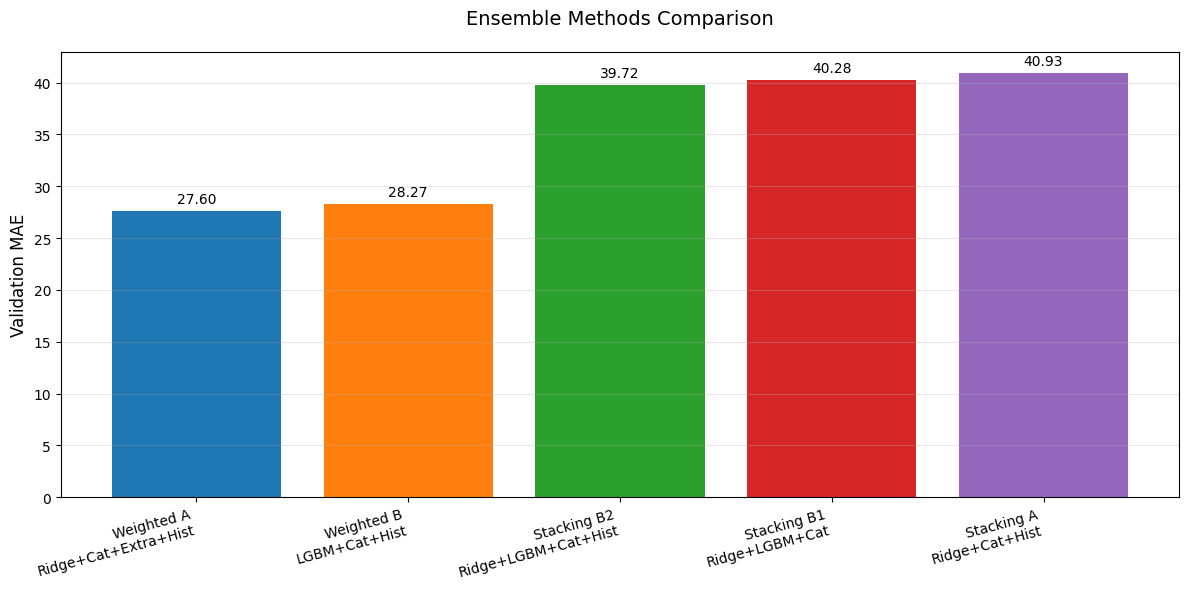

In [18]:
# ============================================================================
# Ensemble Results Comparison
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

# 全アンサンブル結果をまとめる
ensemble_results = [
    {'Method': 'Weighted A', 'Models': 'Ridge+Cat+Extra+Hist', 'MAE': mae_a},
    {'Method': 'Weighted B', 'Models': 'LGBM+Cat+Hist', 'MAE': mae_b},
    {'Method': 'Stacking A', 'Models': 'Ridge+Cat+Hist', 'MAE': mae_stack_a},
    {'Method': 'Stacking B1', 'Models': 'Ridge+LGBM+Cat', 'MAE': mae_stack_b1},
    {'Method': 'Stacking B2', 'Models': 'Ridge+LGBM+Cat+Hist', 'MAE': mae_stack_b2},
]

# ベースモデルの結果も追加
for name, pred in base_predictions_val.items():
    mae = mean_absolute_error(y_test, pred)
    ensemble_results.append({'Method': 'Base Model', 'Models': name, 'MAE': mae})

results_df = pd.DataFrame(ensemble_results)
results_df = results_df.sort_values('MAE').reset_index(drop=True)

print('\n' + '='*80)
print('ENSEMBLE RESULTS COMPARISON')
print('='*80)
print(results_df.to_string(index=False))

# アンサンブル手法のみを抽出してプロット
ensemble_only = results_df[results_df['Method'] != 'Base Model'].copy()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(ensemble_only)), ensemble_only['MAE'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.xticks(range(len(ensemble_only)), 
           [f"{row['Method']}\n{row['Models']}" for _, row in ensemble_only.iterrows()],
           rotation=15, ha='right')
plt.ylabel('Validation MAE', fontsize=12)
plt.title('Ensemble Methods Comparison', fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# 値をバーの上に表示
for i, (bar, mae) in enumerate(zip(bars, ensemble_only['MAE'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{mae:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(f'{output}/ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# CSV保存
results_df.to_csv(f'{output}/ensemble_results.csv', index=False)
print(f'\nResults saved to: {output}/ensemble_results.csv')


In [19]:
# ============================================================================
# Create Submission Files for All Ensembles
# ============================================================================

# アンサンブル予測値を辞書にまとめる
ensemble_predictions = {
    'weighted_a_ridge_cat_extra_hist': weighted_test_a,
    'weighted_b_lgbm_cat_hist': weighted_test_b,
    'stacking_a_ridge_cat_hist': test_stack_a,
    'stacking_b1_ridge_lgbm_cat': test_stack_b1,
    'stacking_b2_ridge_lgbm_cat_hist': test_stack_b2,
}

print('\n' + '='*80)
print('Creating submission files...')
print('='*80)

# 仮のIDを作成（実際のtest_dfにIDがあればそれを使用）
test_ids = range(len(weighted_test_a))

for name, pred in ensemble_predictions.items():
    submission = pd.DataFrame({
        'id': test_ids,
        'target_next_day': pred
    })
    
    filepath = f'{output_dir}/submission_{name}.csv'
    submission.to_csv(filepath, index=False)
    print(f'  Saved: submission_{name}.csv')

print('\nAll submission files created successfully!')



Creating submission files...


NameError: name 'output_dir' is not defined

---
## Summary

**exp11: Ensemble Methods Comparison**

### Ensemble Patterns Tested:

#### 1. Weighted Ensemble (Optimized)
- **Pattern A**: Ridge + CatBoost + ExtraTrees + HistGB
- **Pattern B**: LightGBM + CatBoost + HistGB

#### 2. Stacking Ensemble (Ridge as Meta-learner)
- **Pattern A**: Ridge + CatBoost + HistGB
- **Pattern B1**: Ridge + LightGBM + CatBoost
- **Pattern B2**: Ridge + LightGBM + CatBoost + HistGB

### Key Outputs:
1. `ensemble_results.csv` - All ensemble results comparison
2. `ensemble_comparison.png` - Visual comparison bar chart
3. `submission_*.csv` - Submission files for each ensemble method
